In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import gzip, os


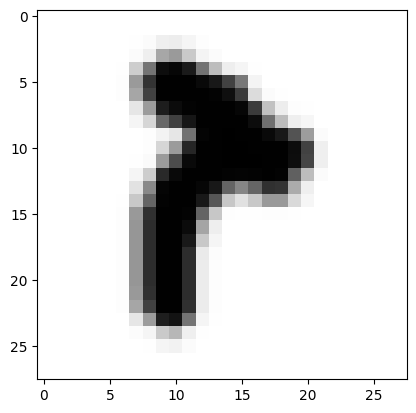

In [2]:
def load_emnist_images(fname):
    with open(fname, 'rb') as f:
        # 讀取 EMNIST 圖像資料
        magic, num_images, rows, cols = np.fromfile(f, dtype='>i4', count=4)
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images, rows, cols

def load_emnist_labels(fname):
    with open(fname, 'rb') as f:
        # 讀取 EMNIST 標籤資料
        magic, num_labels = np.fromfile(f, dtype='>i4', count=2)
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

def preprocess_images(images):
    # 歸一化到 [-1, 1] 範圍
    images = (images / 255.0) * 2.0 - 1.0
    # 重塑為一維向量
    images = images.reshape((images.shape[0], -1))
    return images

train_images, rows, cols = load_emnist_images("../emnist-dataset/emnist-balanced-train-images-idx3-ubyte")
train_labels = load_emnist_labels("../emnist-dataset/emnist-balanced-train-labels-idx1-ubyte")
test_images, _, _ = load_emnist_images("../emnist-dataset/emnist-balanced-test-images-idx3-ubyte")
test_labels = load_emnist_labels("../emnist-dataset/emnist-balanced-test-labels-idx1-ubyte")

# 重塑為原始形狀
original_shape = (rows, cols)
train_images_original_shape = train_images.reshape((train_images.shape[0], *original_shape))
test_images_original_shape = test_images.reshape((test_images.shape[0], *original_shape))

# 顯示第一張圖像
plt.imshow(train_images_original_shape[0], cmap='Greys')
plt.show()



In [3]:
print(len(train_images),len(train_labels),len(test_images),len(test_labels))
print(test_images[0].shape)

112800 112800 18800 18800
(28, 28)


In [4]:
print("train_images.shape：", train_images.shape)
print("train_labels.shape：", train_labels.shape)
print("test_images.shape：", test_images.shape)
print("test_labels.shape：", test_labels.shape)


train_images.shape： (112800, 28, 28)
train_labels.shape： (112800,)
test_images.shape： (18800, 28, 28)
test_labels.shape： (18800,)


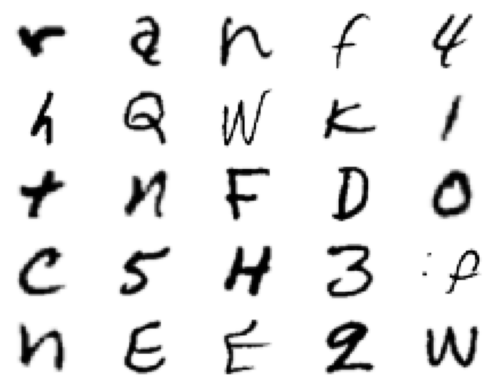

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 顯示 EMNIST 訓練集的前 25 張圖像
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plt.imshow(np.rot90(train_images[i]), cmap='Greys')
    plt.imshow(np.flipud(np.rot90(train_images[i])), cmap='Greys')
    # plt.imshow((train_images[i]), cmap='Greys')

plt.show()


2023-12-26 05:43:44.930301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-26 05:43:44.980357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-26 05:43:44.980522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-26 05:43:44.981283: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0

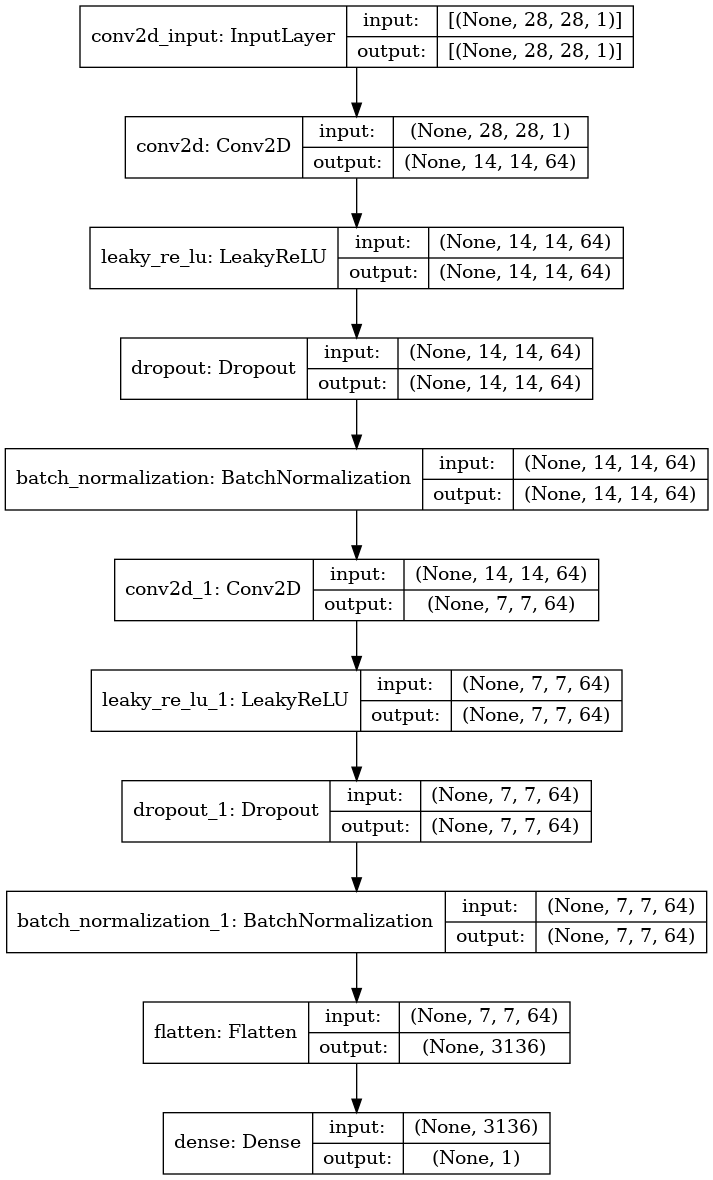

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# 定義判別器模型
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())  # 批量正規化
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())  # 批量正規化
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    # 編譯模型
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define and summarize the Discriminator model
# define model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)      

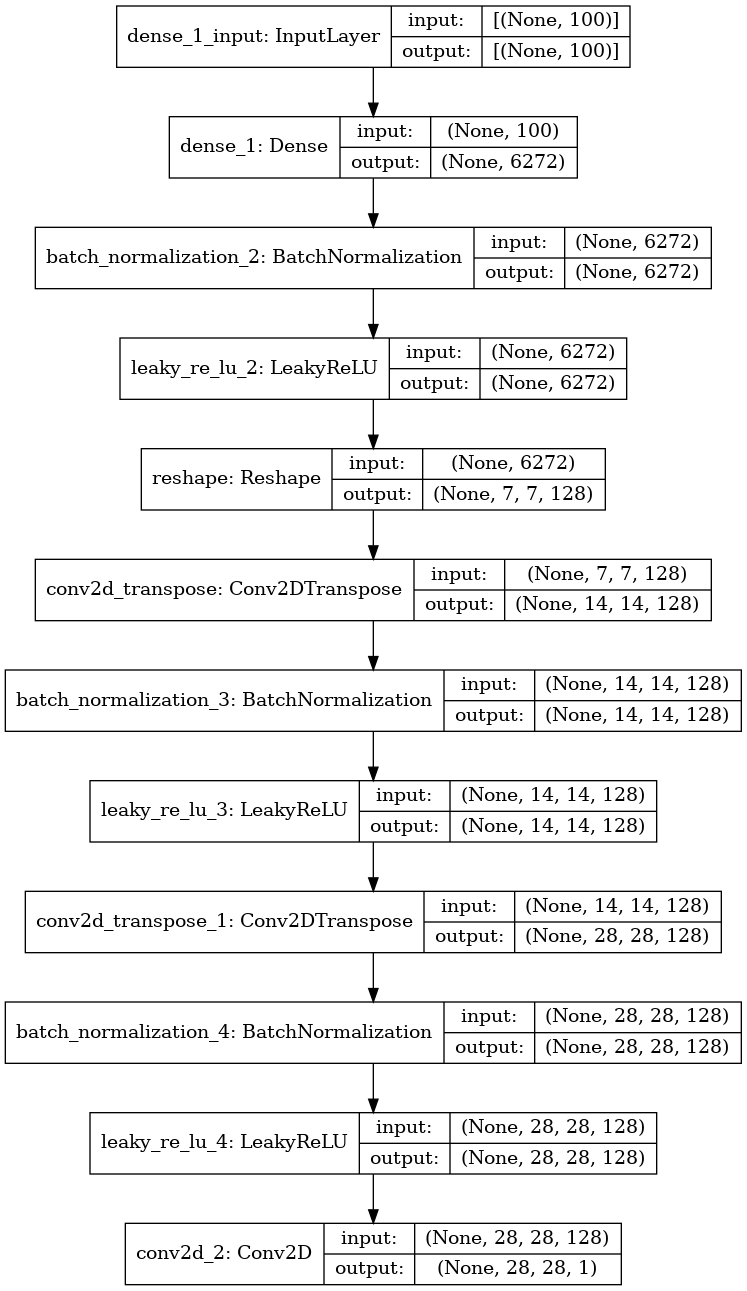

In [7]:

from numpy import zeros
from numpy.random import randn
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal

# 定義生成器模型
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization())  # 批量正規化
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())  # 批量正規化
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(BatchNormalization())  # 批量正規化
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# # 定義生成器模型
# def define_generator(latent_dim):
#     model = Sequential()
#     # foundation for 7x7 image
#     n_nodes = 128 * 7 * 7
#     model.add(Dense(n_nodes, input_dim=latent_dim))
#     model.add(BatchNormalization())  # 批量正規化
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Reshape((7, 7, 128)))
#     # upsample to 14x14
#     model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(BatchNormalization())  # 批量正規化
#     model.add(LeakyReLU(alpha=0.2))
#     # upsample to 28x28
#     model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(BatchNormalization())  # 批量正規化
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
#     return model


# # 定義生成器模型
# def define_generator(latent_dim):
#     model = Sequential()
#     # foundation for 7x7 image
#     n_nodes = 128 * 7 * 7
#     model.add(Dense(n_nodes, input_dim=latent_dim))
#     model.add(BatchNormalization())  # 批量正規化
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Reshape((7, 7, 128)))
#     # upsample to 14x14
#     model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(BatchNormalization())  # 批量正規化
#     model.add(LeakyReLU(alpha=0.2))
#     # upsample to 28x28
#     model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(BatchNormalization())  # 批量正規化
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(1, (7, 7), activation='tanh', padding='same'))
#     return model


# 定義並總結生成器模型
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1190401   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 41217     
Total params: 1,231,618
Trainable params: 1,177,345
Non-trainable params: 54,273
_________________________________________________________________


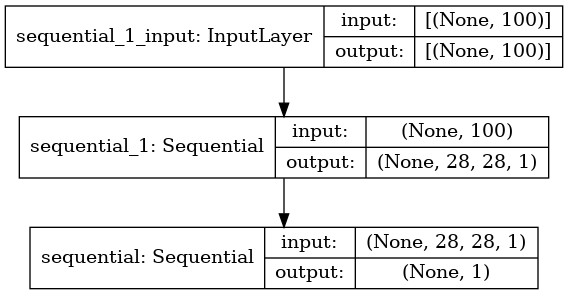

In [8]:
from numpy import zeros
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU

# 定義GAN模型
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# 定義條件GAN模型
def define_conditional_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# 定義GAN模型
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)



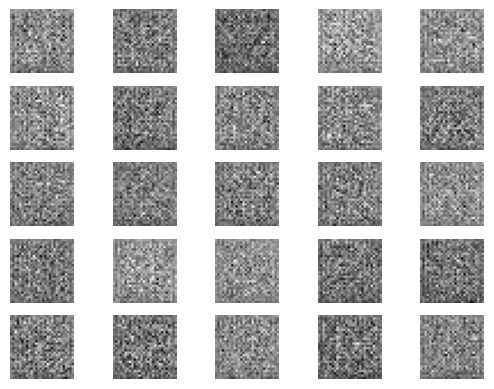

In [16]:
import numpy as np
from numpy import expand_dims, ones, zeros, random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense



# 處理EMNIST數據集
# def load_real_samples():
#     # 載入 EMNIST 圖像數據
#     emnist_images = load_emnist_images("../emnist-dataset/emnist-balanced-train-images-idx3-ubyte")
#     # 擴展維度 (添加 channels 維度)
#     X = expand_dims(emnist_images, axis=-1)
#     # 將圖像數值範圍縮放到 [0,1]
#     X = X.astype('float32') / 255.0
#     return X


def load_real_samples():
    # 載入 EMNIST 圖像數據
    emnist_images, _, _ = load_emnist_images("../emnist-dataset/emnist-balanced-train-images-idx3-ubyte")
    # 確保圖像數據是規則的數組
    emnist_images = np.array(emnist_images, dtype='float32')
    # 擴展維度 (添加 channels 維度)
    X = np.expand_dims(emnist_images, axis=-1)
    # 將圖像數值範圍縮放到 [0,1]
    X = X / 255.0

    return X

# 選擇真實樣本
def generate_real_samples(dataset, n_samples):
    # 隨機選擇實例
    ix = random.randint(0, dataset.shape[0], n_samples)
    # 檢索所選圖像
    X = dataset[ix]
    # 生成 'real' 類別標籤 (1)
    y = ones((n_samples, 1))
    return X, y


def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape((n_samples, latent_dim))
    return x_input


def generate_fake_samples(generator, latent_dim, n_samples):
    # 生成潛在空間中的點
    x_input = generate_latent_points(latent_dim, n_samples)
    # 使用生成器生成假樣本
    X = generator.predict(x_input)
    # 生成 'fake' 類別標籤 (0)
    y = zeros((n_samples, 1))
    return X, y

# 1. Define EMNIST generator model
latent_dim_emnist = 100  # Set the appropriate latent space dimension for EMNIST
generator_model_emnist = define_generator(latent_dim_emnist)

# 2. Generate samples
n_samples_emnist = 25
X_emnist, _ = generate_fake_samples(generator_model_emnist, latent_dim_emnist, n_samples_emnist)


# 3. Plot the generated samples
for i in range(n_samples_emnist):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X_emnist[i, :, :, 0], cmap='gray_r')

# show the figure
plt.show()



In [17]:
# train the composite model
def train_gan(gan_model, generator, discriminator, latent_dim, dataset, n_epochs=100, n_batch=256):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        # gan_model.train_on_batch(x_gan, y_gan)
        
        # update the generator via the discriminator's error
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        print(f">{i + 1}, Generator Loss={generator_loss:.3f}")

        # generate 'fake' samples
        x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_batch)
        # update discriminator on 'fake' samples
        _, fake_acc = discriminator.train_on_batch(x_fake, y_fake)

        # generate 'real' samples
        x_real, y_real = generate_real_samples(dataset, n_batch)
        # update discriminator on 'real' samples
        _, real_acc = discriminator.train_on_batch(x_real, y_real)

        # summarize performance for this epoch
        print(f">{i + 1}, D_real={real_acc:.3f}, D_fake={fake_acc:.3f}")


# Usage example:
# train_gan(gan_model_emnist, generator_model_emnist, discriminator_model_emnist, latent_dim_emnist, dataset_emnist, n_epochs=100, n_batch=256)


In [18]:
import numpy as np

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

# Usage example:
# train(generator_model_emnist, discriminator_model_emnist, gan_model_emnist, dataset_emnist, latent_dim_emnist, n_epochs=20, n_batch=256)


In [19]:
def train_discriminator(model, generator, latent_dim, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# Usage example:
# define the discriminator model
discriminator_model_emnist = define_discriminator()
# define the generator model
generator_model_emnist = define_generator(latent_dim_emnist)
# load image data
dataset_emnist = load_real_samples()
# fit the model
train_discriminator(discriminator_model_emnist, generator_model_emnist, latent_dim_emnist, dataset_emnist)

>1 real=62% fake=31%
>2 real=71% fake=34%
>3 real=77% fake=40%
>4 real=84% fake=45%
>5 real=87% fake=52%
>6 real=88% fake=66%
>7 real=91% fake=65%
>8 real=88% fake=80%
>9 real=97% fake=73%
>10 real=94% fake=83%
>11 real=95% fake=84%
>12 real=97% fake=84%
>13 real=96% fake=90%
>14 real=98% fake=88%
>15 real=97% fake=96%
>16 real=98% fake=93%
>17 real=97% fake=95%
>18 real=98% fake=94%
>19 real=100% fake=96%
>20 real=98% fake=99%
>21 real=98% fake=98%
>22 real=99% fake=100%
>23 real=97% fake=99%
>24 real=98% fake=97%
>25 real=100% fake=100%
>26 real=98% fake=100%
>27 real=98% fake=100%
>28 real=98% fake=100%
>29 real=100% fake=100%
>30 real=99% fake=100%
>31 real=98% fake=100%
>32 real=100% fake=100%
>33 real=98% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=99%
>37 real=99% fake=100%
>38 real=99% fake=100%
>39 real=99% fake=100%
>40 real=99% fake=100%
>41 real=100% fake=100%
>42 real=99% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=100%
>45 real=10

In [20]:
import numpy as np
from numpy import ones, zeros
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense

# 修改 EMNIST 訓練 GAN 的函式
def train_gan(generator, discriminator, gan_model, latent_dim, dataset, n_epochs=100, n_batch=256):
    # 計算每個 batch 中 fake 圖片的一半
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):
        # 1. Train the discriminator
        # 真實樣本
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # 訓練判別器對真實樣本的部分
        d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)

        # 生成樣本
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        # 訓練判別器對生成樣本的部分
        d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)

        # 2. Train the generator
        # 準備生成樣本的潛在空間點
        x_gan = generate_latent_points(latent_dim, n_batch)
        # 創建反向標籤，即全為 1
        y_gan = ones((n_batch, 1))
        # 訓練生成器，通過判別器的誤差
        gan_loss = gan_model.train_on_batch(x_gan, y_gan)

        # 摘要並印出每個 epoch 的結果
        print(f">{i + 1}, D_real={d_loss_real:.3f}, D_fake={d_loss_fake:.3f}, G={gan_loss:.3f}")

# 定義 EMNIST GAN 模型
gan_model_emnist = define_gan(generator_model_emnist, discriminator_model_emnist)
gan_model_emnist.summary()
# 加載 EMNIST 圖像數據
dataset_emnist = load_real_samples()
# 訓練 EMNIST GAN
train_gan(generator_model_emnist, discriminator_model_emnist, gan_model_emnist, latent_dim_emnist, dataset_emnist, n_epochs=100, n_batch=256)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 28, 28, 1)         1190401   
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 41217     
Total params: 1,231,618
Trainable params: 1,177,345
Non-trainable params: 54,273
_________________________________________________________________
>1, D_real=0.006, D_fake=0.003, G=0.984
>2, D_real=0.015, D_fake=0.004, G=0.771
>3, D_real=0.005, D_fake=0.003, G=0.586
>4, D_real=0.009, D_fake=0.005, G=0.479
>5, D_real=0.007, D_fake=0.003, G=0.411
>6, D_real=0.009, D_fake=0.004, G=0.356
>7, D_real=0.019, D_fake=0.002, G=0.317
>8, D_real=0.004, D_fake=0.004, G=0.285
>9, D_real=0.006, D_fake=0.003, G=0.254
>10, D_real=0.024, D_fake=0.004, G=0.227
>11, D_real=0.004, D_fake=0.002, G=0.215
>12, D_real=0.005, D_fake=0.003, G=0.197
>13, D_real=0.006

In [21]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        # Reshape to (28, 28) if the examples are flattened
        if examples.shape[3] == 1:
            img = examples[i, :, :, 0]
        else:
            img = examples[i, :, :, :]
        plt.imshow(img, cmap='gray_r', aspect='auto')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [22]:
# 修改 summarize_performance 函數
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [24]:
import numpy as np
from numpy import ones

# 定義 EMNIST 訓練函數
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim_emnist = 100
# create the discriminator
d_model_emnist = define_discriminator()
# create the generator
g_model_emnist = define_generator(latent_dim_emnist)
# create the gan
gan_model_emnist = define_gan(g_model_emnist, d_model_emnist)
# load image data
dataset_emnist = load_real_samples()
# train model
train(g_model_emnist, d_model_emnist, gan_model_emnist, dataset_emnist, latent_dim_emnist)


>1, 1/440, d=1.080, g=0.726
>1, 2/440, d=0.699, g=0.699
>1, 3/440, d=0.630, g=0.683
>1, 4/440, d=0.555, g=0.679
>1, 5/440, d=0.479, g=0.671
>1, 6/440, d=0.361, g=0.664
>1, 7/440, d=0.298, g=0.663
>1, 8/440, d=0.261, g=0.657
>1, 9/440, d=0.231, g=0.653
>1, 10/440, d=0.177, g=0.655
>1, 11/440, d=0.163, g=0.648
>1, 12/440, d=0.150, g=0.647
>1, 13/440, d=0.137, g=0.644
>1, 14/440, d=0.113, g=0.642
>1, 15/440, d=0.117, g=0.635
>1, 16/440, d=0.099, g=0.634
>1, 17/440, d=0.086, g=0.628
>1, 18/440, d=0.093, g=0.626
>1, 19/440, d=0.076, g=0.623
>1, 20/440, d=0.064, g=0.621
>1, 21/440, d=0.056, g=0.615
>1, 22/440, d=0.070, g=0.614
>1, 23/440, d=0.044, g=0.611
>1, 24/440, d=0.042, g=0.610
>1, 25/440, d=0.051, g=0.607
>1, 26/440, d=0.038, g=0.604
>1, 27/440, d=0.046, g=0.599
>1, 28/440, d=0.041, g=0.597
>1, 29/440, d=0.047, g=0.593
>1, 30/440, d=0.043, g=0.591
>1, 31/440, d=0.039, g=0.586
>1, 32/440, d=0.030, g=0.584
>1, 33/440, d=0.037, g=0.582
>1, 34/440, d=0.028, g=0.578
>1, 35/440, d=0.030, g=

In [25]:
generator_model.save('generator_model.h5')

discriminator_model.save('discriminator_model.h5')

gan_model.save('gan_model.h5')


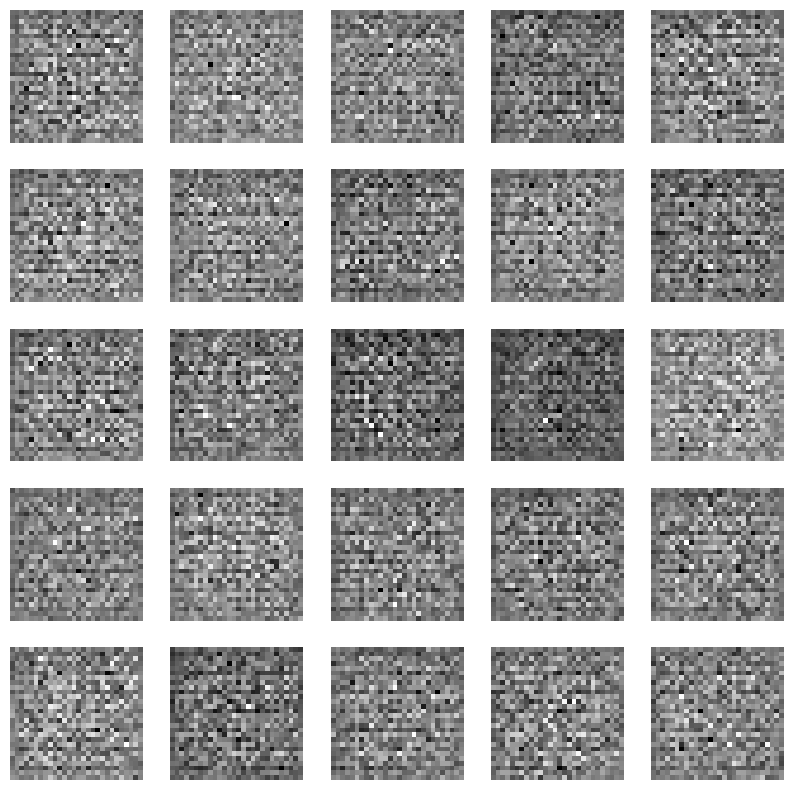

In [26]:
from numpy import asarray
from numpy.random import randn
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 載入 generator 模型
model = load_model('generator_model.h5')

# 生成 latent points
latent_points = generate_latent_points(100, 25)

# 生成影像
X = model.predict(latent_points)

# 將像素值縮放到 [0, 1] 範圍
X = (X + 1) / 2.0

# 顯示生成的影像
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray')
plt.show()


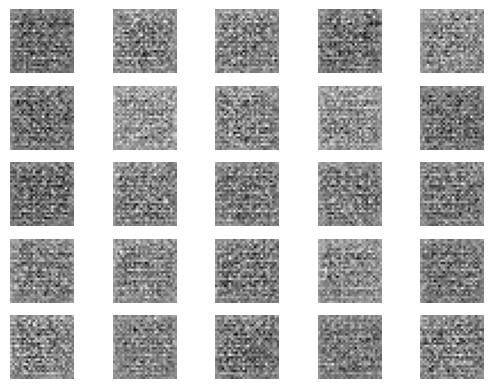

In [27]:
from numpy import asarray
from numpy.random import randn
from tensorflow.keras.models import load_model

model = load_model('generator_model.h5')

# 生成 latent points
latent_points = generate_latent_points(100, 25)

# 生成影像
X = model.predict(latent_points)

# 將像素值縮放到 [0, 1] 範圍
X = (X + 1) / 2.0

# 顯示生成的影像
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray_r')

# 顯示圖片
plt.show()


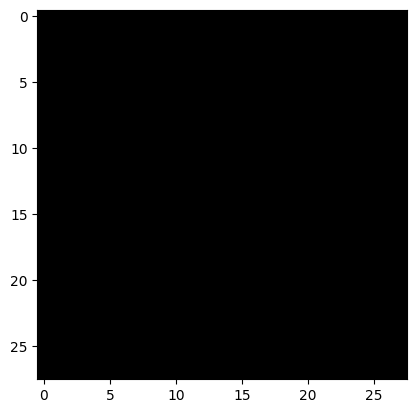

In [28]:
# 載入模型
model = load_model('generator_model.h5')

# 產生一個 latent space 中特定點的影像
# 這裡使用全為 0 的向量作為例子
vector = asarray([[0.0 for _ in range(100)]])

# 生成影像
X = model.predict(vector)

# 顯示結果
plt.imshow(X[0, :, :, 0], cmap='gray')
plt.show()